#### Cybersecurity Anomalous Behavior detection Using Machine Learning and other data science techniquesc
**Note: This project is currently under development**

**Toronto, October 26 2024**  
**Autor : Atsu Vovor** 
>Master of Management in Artificial Intelligence,  
>Consultant Data Analytics Specialist | Machine Learning | Data science | Quantitative Analysis |French & English Bilingual  


#### Description:

This project, create a synthetic dataset representing user activity logs, with features that typically indicate behavior patterns. I have Included some rows with anomalous patterns like high login attempts, unusual session duration, or high data transfer volumes from unexpected locations. Isolation Forest , One-Class Support Vector Machines (SVM) and  Density-Based Spatial Clustering of Applications with Noise(DBSCAN)  techniques are applied to detect anomalies.

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, roc_auc_score


#### Step 1: Generate a Synthetic Dataset
Let's create a synthetic dataset representing user activity logs, with features that typically indicate behavior patterns.

**1. Features:**

  - user_id: Identifier for each user.  
  - timestamp: Time of the activity.  
  - activity_type: Type of activity (e.g., "login," "file_access," "data_modification").  
  - location: User's location (e.g., IP region).  
  - session_duration: Length of session in seconds.  
  - num_files_accessed: Number of files accessed in a session.  
  - ogin_attempts: Number of login attempts in a session.  
  - data_transfer_MB: Amount of data transferred (MB).  


**2.  Anomalies:**

Include some rows with anomalous patterns like high login attempts, unusual session duration, or high data transfer volumes from unexpected locations.

**3.  Code for Dataset Generation:** Here’s a Python code snippet to generate this dataset:

In [2]:

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
num_records = 10000
user_ids = [f"user_{i}" for i in range(1, 201)]  # 200 users
activity_types = ["login", "file_access", "data_modification"]
locations = ["US", "CA", "DE", "FR", "JP", "CN"]

data = {
    "user_id": np.random.choice(user_ids, num_records),
    "timestamp": [datetime.now() - timedelta(minutes=random.randint(0, 10000)) for _ in range(num_records)],
    "activity_type": np.random.choice(activity_types, num_records),
    "location": np.random.choice(locations, num_records),
    "session_duration": np.random.normal(300, 100, num_records).astype(int),  # Average 5 mins, Std 1.5 mins
    "num_files_accessed": np.random.poisson(2, num_records),
    "login_attempts": np.random.poisson(1, num_records),
    "data_transfer_MB": np.random.exponential(5, num_records)
}

df = pd.DataFrame(data)

# Inject some anomalies
anomalies = df.sample(frac=0.01)
df.loc[anomalies.index, "session_duration"] = df["session_duration"] * np.random.randint(5, 20)
df.loc[anomalies.index, "login_attempts"] = df["login_attempts"] + np.random.randint(10, 20)
df.loc[anomalies.index, "data_transfer_MB"] = df["data_transfer_MB"] * np.random.randint(10, 50)

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
display(df)

,user_id,timestamp,activity_type,location,session_duration,num_files_accessed,login_attempts,data_transfer_MB
0,user_64,2024-10-27 11:08:28.320409,file_access,DE,6750,1,21,24.846440
1,user_172,2024-10-28 01:52:28.323425,login,DE,352,2,2,2.266125
2,user_111,2024-10-22 09:31:28.323425,data_modification,FR,339,2,1,7.950173
3,user_194,2024-10-28 05:26:28.333075,data_modification,CN,413,0,0,3.817774
4,user_198,2024-10-27 16:03:28.321417,login,CA,263,0,2,0.888217
...,...,...,...,...,...,...,...,...
9995,user_11,2024-10-26 22:46:28.322421,login,CA,511,2,0,4.314129
9996,user_61,2024-10-26 03:27:28.314341,login,US,119,1,1,5.992105
9997,user_126,2024-10-25 11:12:28.333075,login,DE,243,4,1,0.828037
9998,user_167,2024-10-22 20:21:28.323425,login,DE,353,0,2,3.577702


#### Step 2: Exploratory Data Analysis (EDA)
To perform Exploratory Data Analysis (EDA) on this synthetic dataset, we’ll dive  
into visualizing feature distributions, spotting potential outliers, and understanding  
relationships among features.


**1. Visualize the Features:**  
     We'll create histograms and boxplots for the session_duration, login_attempts,   
     and data_transfer_MB features to understand their      distributions and identify any  
     unusual patterns.

C:\Users\atsuv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\atsuv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\atsuv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


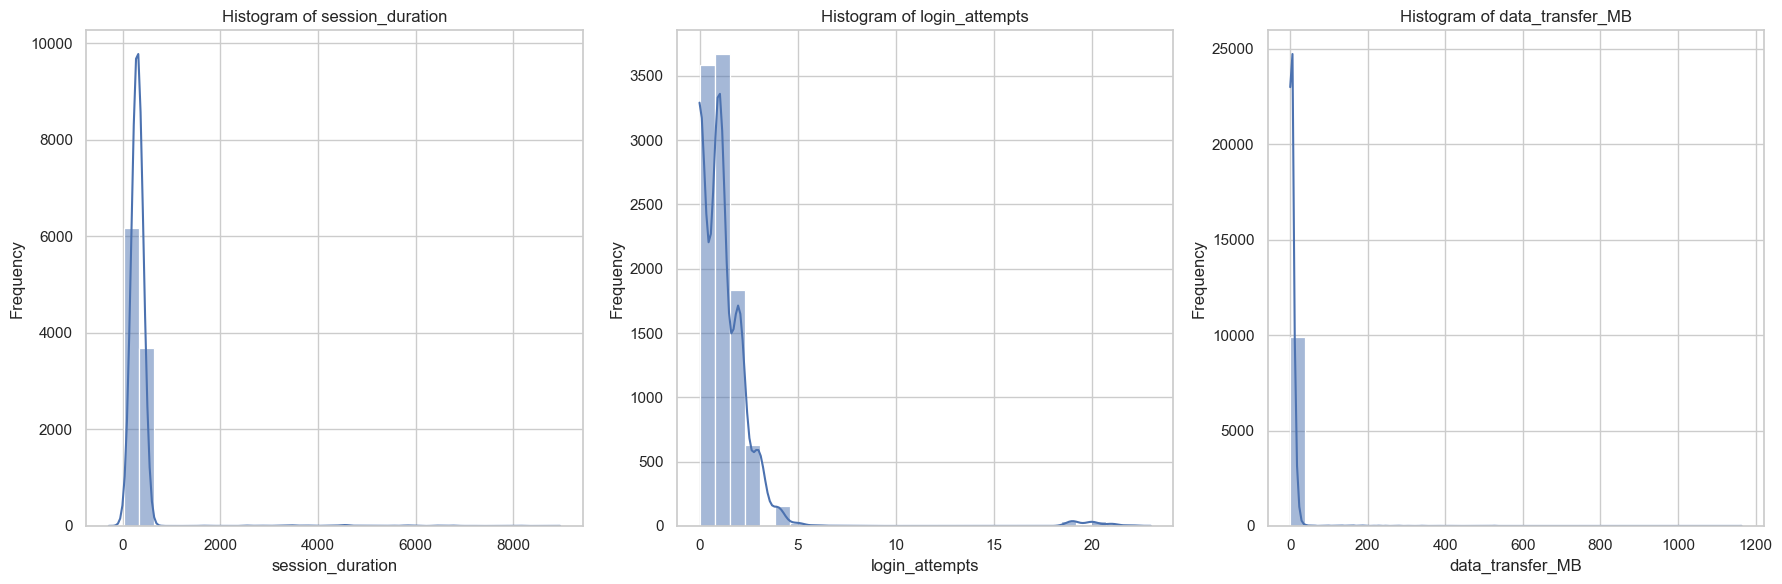

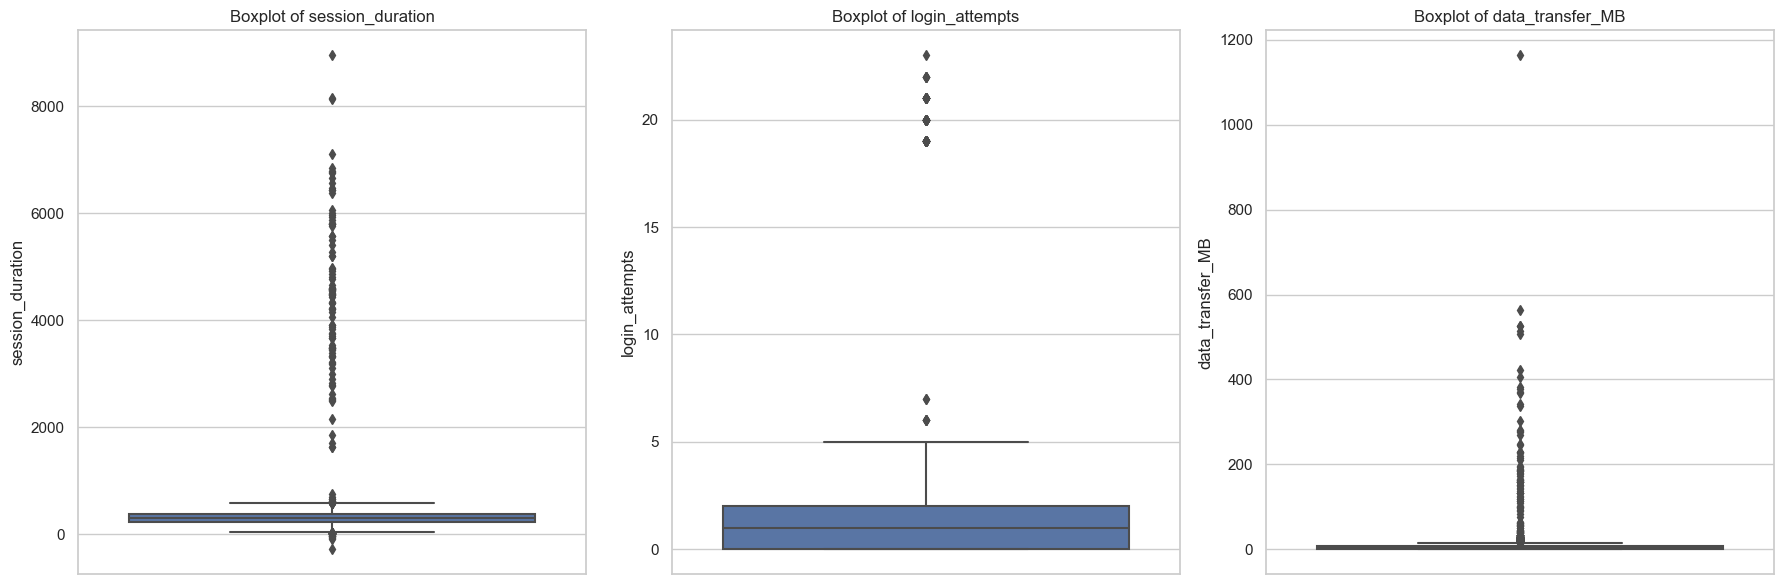

In [3]:

# Set plot style
sns.set(style="whitegrid")

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
features = ['session_duration', 'login_attempts', 'data_transfer_MB']

for i, feature in enumerate(features):
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, feature in enumerate(features):
    sns.boxplot(y=df[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()


**Interpretation:**

  - Histograms: These help us see the general distribution of each feature.   
    KDE curves can highlight skewness, and a long right tail might suggest the presence of outliers.  
  - Boxplots: Useful for spotting outliers as they display the interquartile range (IQR),  
    with points outside 1.5 times the IQR from the quartiles typically considered outliers.  
    

#### **2. Identify Outliers:**  

We can use scatter plots to detect high login_attempts or data_transfer_MB values and examine correlations to identify anomalous patterns.


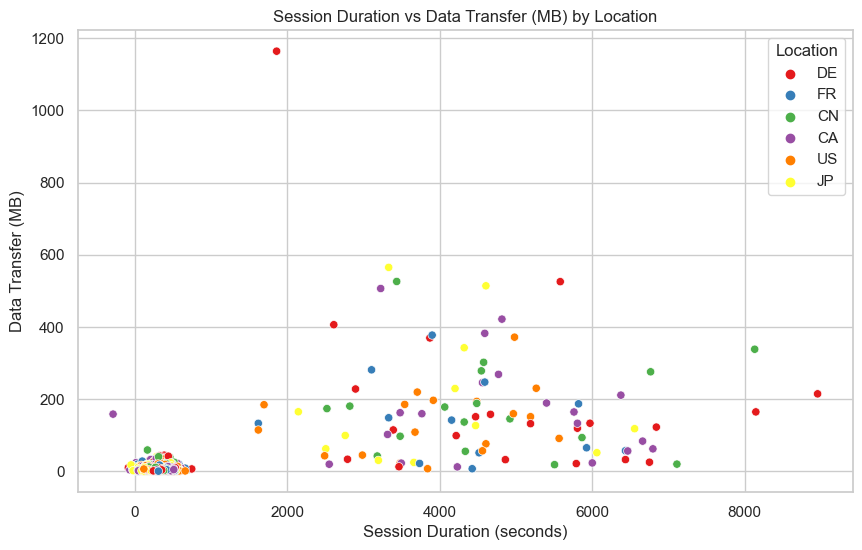

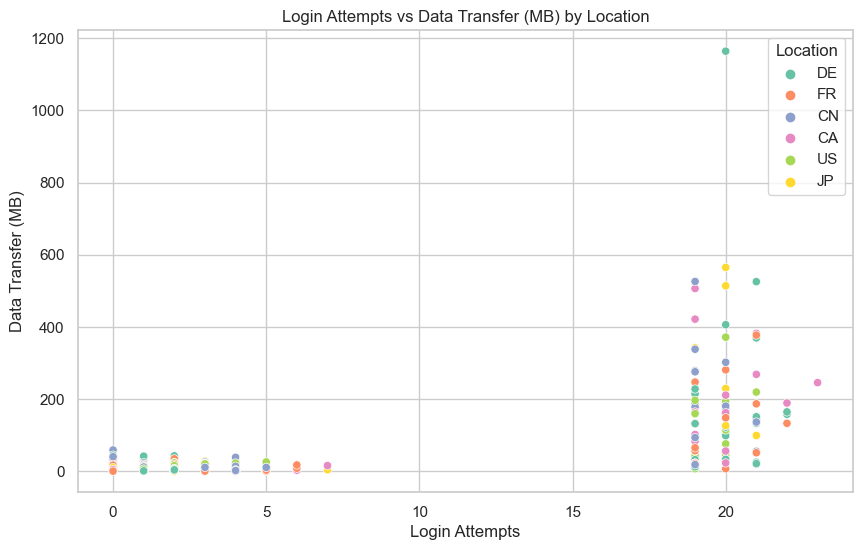

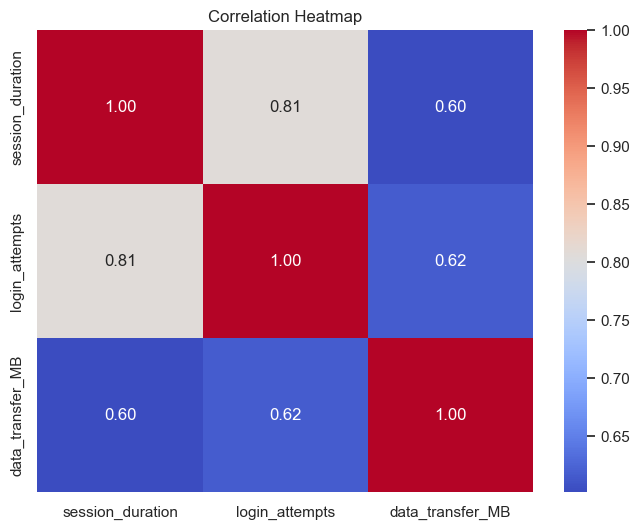

In [4]:
# Scatter plot: Session Duration vs Data Transfer
plt.figure(figsize=(10, 6))
sns.scatterplot(x='session_duration', y='data_transfer_MB', hue='location', data=df, palette="Set1")
plt.title("Session Duration vs Data Transfer (MB) by Location")
plt.xlabel("Session Duration (seconds)")
plt.ylabel("Data Transfer (MB)")
plt.legend(title="Location")
plt.show()

# Scatter plot: Login Attempts vs Data Transfer
plt.figure(figsize=(10, 6))
sns.scatterplot(x='login_attempts', y='data_transfer_MB', hue='location', data=df, palette="Set2")
plt.title("Login Attempts vs Data Transfer (MB) by Location")
plt.xlabel("Login Attempts")
plt.ylabel("Data Transfer (MB)")
plt.legend(title="Location")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


**Interpretation:**  

  - Scatter plots:
     - **Session Duration vs. Data Transfer (MB):** Points with extremely high values in either feature might 
         indicate anomalies. High data transfer over short sessions or prolonged sessions with minimal data  
         transfer could be unusual.
     - **Login Attempts vs. Data Transfer (MB):** Abnormally high login attempts combined with substantial  
         data transfer, particularly from specific locations, might indicate suspicious behavior.  
         
  - **Correlation Heatmap:** This helps identify relationships among the features. Strong positive or negative  
      correlations could indicate normal vs. abnormal behavioral patterns.
      
These visualizations give insight into typical vs. atypical behavior, making it easier to flag data points for further analysis using anomaly detection techniques.


#### Step 3: Anomaly Detection Techniques
Here we will use Isolation Forest , One-Class Support Vector Machines (SVM) and   
Density-Based Spatial Clustering of Applications with Noise(DBSCAN)  techniques to detect anomalies:

**1. Isolation Forest:**

These codes are using the IsolationForest algorithm from the scikit-learn library to detect anomalies in a dataset. 

The first line imports the IsolationForest class from the sklearn.ensemble module.

The second line creates an instance of the IsolationForest class with the parameters n_estimators=100, contamination=0.01, and random_state=42. 
- n_estimators specifies the number of base estimators in the ensemble.
- contamination specifies the proportion of outliers in the dataset.
- random_state is used to initialize the random number generator.

The third line fits the IsolationForest model to the dataset and computes the anomaly score for each data point based on the features 'session_duration', 'login_attempts', and 'data_transfer_MB'. The anomaly scores are then added as a new column 'anomaly_score' to the dataframe df.

The fourth line marks anomalies by creating a new column 'is_anomaly' in the dataframe df. This column is set to True for data points with an anomaly score of -1, indicating that they are considered as anomalies by the IsolationForest model.

In [5]:

isolation_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
isolation_forest_df = df.copy()
isolation_forest_df['anomaly_score'] = isolation_forest.fit_predict(isolation_forest_df[['session_duration', 
                                                                                         'login_attempts', 'data_transfer_MB']])

# Mark anomalies
isolation_forest_df['is_anomaly'] = isolation_forest_df['anomaly_score'] == -1

display(isolation_forest_df)

,user_id,timestamp,activity_type,location,session_duration,num_files_accessed,login_attempts,data_transfer_MB,anomaly_score,is_anomaly
0,user_64,2024-10-27 11:08:28.320409,file_access,DE,6750,1,21,24.846440,-1,True
1,user_172,2024-10-28 01:52:28.323425,login,DE,352,2,2,2.266125,1,False
2,user_111,2024-10-22 09:31:28.323425,data_modification,FR,339,2,1,7.950173,1,False
3,user_194,2024-10-28 05:26:28.333075,data_modification,CN,413,0,0,3.817774,1,False
4,user_198,2024-10-27 16:03:28.321417,login,CA,263,0,2,0.888217,1,False
...,...,...,...,...,...,...,...,...,...,...
9995,user_11,2024-10-26 22:46:28.322421,login,CA,511,2,0,4.314129,1,False
9996,user_61,2024-10-26 03:27:28.314341,login,US,119,1,1,5.992105,1,False
9997,user_126,2024-10-25 11:12:28.333075,login,DE,243,4,1,0.828037,1,False
9998,user_167,2024-10-22 20:21:28.323425,login,DE,353,0,2,3.577702,1,False


**2. One-Class Support Vector Machines (SVM):**

This code imports the OneClassSVM class from the sklearn.svm module. It then creates a OneClassSVM object with specified parameters (nu=0.01, kernel="rbf", gamma=0.1). The object is then used to fit the model to the data and predict the anomaly scores for each data point based on the features 'session_duration', 'login_attempts', and 'data_transfer_MB'. These anomaly scores are then assigned to a new column called 'svm_score' in the dataframe 'df'. Finally, a new column called 'is_anomaly_svm' is created in the dataframe to indicate whether each data point is an anomaly based on the SVM model's predictions. Anomaly points are labeled as True, while normal points are labeled as False.

In [6]:

svm_df = df.copy()

svm = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
svm_df['svm_score'] = svm.fit_predict(svm_df[['session_duration', 'login_attempts', 'data_transfer_MB']])
svm_df['is_anomaly_svm'] = svm_df['svm_score'] == -1
display(svm_df)

,user_id,timestamp,activity_type,location,session_duration,num_files_accessed,login_attempts,data_transfer_MB,svm_score,is_anomaly_svm
0,user_64,2024-10-27 11:08:28.320409,file_access,DE,6750,1,21,24.846440,1,False
1,user_172,2024-10-28 01:52:28.323425,login,DE,352,2,2,2.266125,1,False
2,user_111,2024-10-22 09:31:28.323425,data_modification,FR,339,2,1,7.950173,1,False
3,user_194,2024-10-28 05:26:28.333075,data_modification,CN,413,0,0,3.817774,1,False
4,user_198,2024-10-27 16:03:28.321417,login,CA,263,0,2,0.888217,1,False
...,...,...,...,...,...,...,...,...,...,...
9995,user_11,2024-10-26 22:46:28.322421,login,CA,511,2,0,4.314129,-1,True
9996,user_61,2024-10-26 03:27:28.314341,login,US,119,1,1,5.992105,1,False
9997,user_126,2024-10-25 11:12:28.333075,login,DE,243,4,1,0.828037,1,False
9998,user_167,2024-10-22 20:21:28.323425,login,DE,353,0,2,3.577702,1,False


**3. Density-Based Spatial Clustering of Applications with Noise(DBSCAN):**  

  - These codes import the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm from the scikit-learn library. Then, it initializes a DBSCAN object with specified parameters for epsilon (eps) and minimum number of samples (min_samples). 

  - DBSCAN assigns a label -1 to points it considers as noise(These noise points are often taken as anomalies) and unique integer labels to each identified cluster. This creates multiple labels rather than a binary (0 or 1) format.

  - The choice of eps (radius around a point for it to count as a neighbor) and min_samples (minimum number of points to form a cluster) is crucial for detecting anomalies. Tuning these parameters based on data characteristics (e.g., density and distance) helps DBSCAN effectively separate normal and anomalous regions.

  - The algorithm is then applied to the specified columns in the dataframe (session_duration, login_attempts, data_transfer_MB) using the fit_predict method, and the resulting cluster labels are stored in a new column called 'dbscan_labels' in the dataframe.

  - Finally, a new column called 'is_anomaly_dbscan' is created in the dataframe to identify anomalies by checking if the dbscan_labels are equal to -1, which is the label assigned to outliers or anomalies by DBSCAN.

  - Since DBSCAN is not a supervised method, it doesn’t inherently produce class labels (like in classification) but rather identifies dense regions as clusters and sparse regions as noise. However, we can compare DBSCAN's clustering output with ground-truth labels as we have labeled data, and calculate evaluation metrics such as a confusion matrix, precision, recall, F1-score, and ROC/Precision-Recall

  - To evaluate anomaly detection wee will convert DBSCAN’s output to a binary format where:

    - 1 represents anomalies (noise points, labeled -1 by DBSCAN).
    - 0 represents normal points (clustered points, labeled with integer cluster labels).
.




In [7]:

dbscan_df = df.copy()
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_df['dbscan_labels'] = dbscan.fit_predict(dbscan_df[['session_duration', 'login_attempts', 'data_transfer_MB']])
dbscan_df['is_anomaly_dbscan'] = dbscan_df['dbscan_labels'] == -1

#Convert y_true (ground-truth labels) to binary 1 for anomalies, 0 for normal
dbscan_df['dbscan_labels_y_true_binary'] = np.where(dbscan_df['dbscan_labels'] == -1, 1, 0) 

#Convert DBSCAN Labels to Binary
dbscan_df['is_anomaly_dbscan_y_pred_binary'] = np.where(dbscan_df['dbscan_labels'] == -1, 1, 0)
dbscan_df['is_anomaly_dbscan_y_pred_True_False'] = dbscan_df['is_anomaly_dbscan_y_pred_binary'] == 1

display(dbscan_df)

print(np.unique(dbscan_df['dbscan_labels']))
print(np.unique(dbscan_df['is_anomaly_dbscan']))
print('convertion')
print('dbscan_labels_y_true_binary: ', np.unique(dbscan_df['dbscan_labels_y_true_binary']))
print('is_anomaly_dbscan_y_pred_binary: ',np.unique(dbscan_df['is_anomaly_dbscan_y_pred_binary']))
print('is_anomaly_dbscan_y_pred_True_False: ',np.unique(dbscan_df['is_anomaly_dbscan_y_pred_True_False']))

,user_id,timestamp,activity_type,location,session_duration,num_files_accessed,login_attempts,data_transfer_MB,dbscan_labels,is_anomaly_dbscan,dbscan_labels_y_true_binary,is_anomaly_dbscan_y_pred_binary,is_anomaly_dbscan_y_pred_True_False
0,user_64,2024-10-27 11:08:28.320409,file_access,DE,6750,1,21,24.846440,-1,True,1,1,True
1,user_172,2024-10-28 01:52:28.323425,login,DE,352,2,2,2.266125,-1,True,1,1,True
2,user_111,2024-10-22 09:31:28.323425,data_modification,FR,339,2,1,7.950173,-1,True,1,1,True
3,user_194,2024-10-28 05:26:28.333075,data_modification,CN,413,0,0,3.817774,-1,True,1,1,True
4,user_198,2024-10-27 16:03:28.321417,login,CA,263,0,2,0.888217,-1,True,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,user_11,2024-10-26 22:46:28.322421,login,CA,511,2,0,4.314129,-1,True,1,1,True
9996,user_61,2024-10-26 03:27:28.314341,login,US,119,1,1,5.992105,-1,True,1,1,True
9997,user_126,2024-10-25 11:12:28.333075,login,DE,243,4,1,0.828037,-1,True,1,1,True
9998,user_167,2024-10-22 20:21:28.323425,login,DE,353,0,2,3.577702,-1,True,1,1,True


[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118]
[False  True]
convertion
dbscan_labels_y_true_binary:  [0 1]
is_anomaly_dbscan_y_pred_binary:  [0 1]
is_anomaly_dbscan_y_pred_True_False:  [False  True]


#### Step 4: Evaluate and Visualize Results
To evaluate and visualize the anomaly detection results, we’ll assess the model's performance  
using metrics and visualization techniques. Assuming we have labels for true anomalies, we can  
measure performance using confusion matrices and precision-recall metrics. Here’s how to proceed  
with each part of the evaluation:


#### **1. Evaluation:**

  - **Confusion Matrix:** This helps us understand the number of true positives (correctly identified anomalies),  
    false positives (normal points misclassified as anomalies), true negatives (correctly identified normal points),  
    and false negatives (anomalies missed by the model).  
  - **Precision, Recall, and F1-Score:** Precision measures the accuracy of the anomaly detection (i.e., the proportion    
    of true positives among all positive predictions). Recall measures the detection rate (i.e., the proportion of true  
    positives out of all actual anomalies). F1-score balances precision and recall.  


Here’s the code for evaluation metrics:  
These codes utilize various functions from the sklearn.metrics module to evaluate the performance of a model for anomaly detection.

The confusion matrix is calculated using the true labels and predicted labels. It provides a summary of the model's performance, showing the counts of true positive, false positive, true negative, and false negative predictions.

The precision, recall, and F1 score are then calculated based on the confusion matrix. Precision measures the proportion of true positive predictions out of all positive predictions, while recall measures the proportion of true positive predictions out of all actual positives. The F1 score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance.

Lastly, the proportion of detected anomalies is calculated by dividing the sum of predicted anomalies by the total number of samples. This gives an indication of how many anomalies were successfully detected by the model.

Overall, these codes provide a comprehensive evaluation of the model's performance for anomaly detection, using standard metrics such as precision, recall, and F1 score.    


### isolation_forest

In [8]:


# Assuming we have a true labels column 'true_labels' where 1 indicates an anomaly and 0 indicates normal
# And a predicted labels column 'is_anomaly' from our model predictions
#isolation_forest
# Confusion matrix
cm = confusion_matrix(isolation_forest_df['anomaly_score'], isolation_forest_df['is_anomaly'])
print("Confusion Matrix:\n", cm)

# Get unique classes and count
class_labels = np.unique(isolation_forest_df['anomaly_score'])
#num_classes = len(unique_classes)
num_classes = cm.shape[0]

# Confirm number of classes matches cm.shape[0]
if len(class_labels) == cm.shape[0]:
    print("Class labels:", class_labels)
else:
    print("Mismatch in the number of classes.")

#class_labels = ['Class 0', 'Class 1', 'Class 2']

print("Classes in the data:", class_labels)
print("Number of classes:", num_classes)

# Precision, Recall, and F1-Score
precision = precision_score(isolation_forest_df['anomaly_score'], isolation_forest_df['is_anomaly'],
                            average='macro')
recall = recall_score(isolation_forest_df['anomaly_score'], isolation_forest_df['is_anomaly'], average='macro')
f1 = f1_score(isolation_forest_df['anomaly_score'], isolation_forest_df['is_anomaly'], average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Proportion of detected anomalies
detected_anomalies = isolation_forest_df['is_anomaly'].sum() / len(isolation_forest_df)
print(f"Proportion of Detected Anomalies: {detected_anomalies:.2%}")


Confusion Matrix:
 [[   0    0  100]
 [   0    0    0]
 [   0 9900    0]]
Mismatch in the number of classes.
Classes in the data: [-1  1]
Number of classes: 3
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Proportion of Detected Anomalies: 1.00%


C:\Users\atsuv\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\atsuv\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### One-Class Support Vector Machines (SVM) 

In [9]:


# Assuming we have a true labels column 'true_labels' where 1 indicates an anomaly and 0 indicates normal
# And a predicted labels column 'is_anomaly' from our model predictions
#isolation_forest
# Confusion matrix
cm = confusion_matrix(svm_df['svm_score'], svm_df['is_anomaly_svm'])
print("Confusion Matrix:\n", cm)

# Get unique classes and count
svm_class_labels = np.unique(svm_df['svm_score'])
#num_classes = len(unique_classes)
svm_num_classes = cm.shape[0]

# Confirm number of classes matches cm.shape[0]
if len(svm_class_labels) == cm.shape[0]:
    print("Class labels:", svm_class_labels)
else:
    print("Mismatch in the number of classes.")

#class_labels = ['Class 0', 'Class 1', 'Class 2']

print("Classes in the data:", svm_class_labels)
print("Number of classes:", svm_num_classes)

# Precision, Recall, and F1-Score
precision = precision_score(svm_df['svm_score'], svm_df['is_anomaly_svm'],
                            average='macro')
recall = recall_score(svm_df['svm_score'], svm_df['is_anomaly_svm'], average='macro')
f1 = f1_score(svm_df['svm_score'], svm_df['is_anomaly_svm'], average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Proportion of detected anomalies
detected_anomalies = svm_df['is_anomaly_svm'].sum() / len(svm_df)
print(f"Proportion of Detected Anomalies: {detected_anomalies:.2%}")

Confusion Matrix:
 [[   0    0 1310]
 [   0    0    0]
 [   0 8690    0]]
Mismatch in the number of classes.
Classes in the data: [-1  1]
Number of classes: 3
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Proportion of Detected Anomalies: 13.10%


C:\Users\atsuv\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\atsuv\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**  

In [10]:


# Assuming we have a true labels column 'true_labels' where 1 indicates an anomaly and 0 indicates normal
# And a predicted labels column 'is_anomaly' from our model predictions
#isolation_forest
# Confusion matrix

#print('dbscan_labels_y_true_binary: ', np.unique(dbscan_df['dbscan_labels_y_true_binary']))
#print('is_anomaly_dbscan_y_pred_binary: ',np.unique(dbscan_df['is_anomaly_dbscan_y_pred_binary']))
#print('is_anomaly_dbscan_y_pred_True_False: ',np.unique(dbscan_df['is_anomaly_dbscan_y_pred_True_False']))

#cm = confusion_matrix(dbscan_df['dbscan_labels'], dbscan_df['is_anomaly_dbscan'])
cm = confusion_matrix(dbscan_df['dbscan_labels_y_true_binary'], dbscan_df['is_anomaly_dbscan_y_pred_True_False'])
print("Confusion Matrix:\n", cm)

# Get unique classes and count
dbscan_class_labels = np.unique(dbscan_df['dbscan_labels_y_true_binary'])
#num_classes = len(unique_classes)
dbscan_num_classes = cm.shape[0]

# Confirm number of classes matches cm.shape[0]
if len(dbscan_class_labels) == cm.shape[0]:
    print("Class labels:", dbscan_class_labels)
else:
    print("Mismatch in the number of classes.")

#class_labels = ['Class 0', 'Class 1', 'Class 2']

print("Classes in the data:", dbscan_class_labels)
print("Number of classes:", dbscan_num_classes)

# Precision, Recall, and F1-Score
#precision = precision_score(dbscan_df['dbscan_labels'], dbscan_df['is_anomaly_dbscan'], average='macro')

precision = precision_score(dbscan_df['dbscan_labels_y_true_binary'], dbscan_df['is_anomaly_dbscan_y_pred_True_False'], average='macro')

#recall = recall_score(dbscan_df['dbscan_labels'], dbscan_df['is_anomaly_dbscan'], average='macro')
#f1 = f1_score(dbscan_df['dbscan_labels'], dbscan_df['is_anomaly_dbscan'], average='macro')

recall = recall_score(dbscan_df['dbscan_labels_y_true_binary'], dbscan_df['is_anomaly_dbscan_y_pred_True_False'], average='macro')
f1 = f1_score(dbscan_df['dbscan_labels_y_true_binary'], dbscan_df['is_anomaly_dbscan_y_pred_True_False'], average='macro')



print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Proportion of detected anomalies
detected_anomalies = dbscan_df['is_anomaly_dbscan'].sum() / len(dbscan_df)
print(f"Proportion of Detected Anomalies: {detected_anomalies:.2%}")



Confusion Matrix:
 [[ 677    0]
 [   0 9323]]
Class labels: [0 1]
Classes in the data: [0 1]
Number of classes: 2
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Proportion of Detected Anomalies: 93.23%


**2. Visualization:**  

  - **Scatter Plots of Clusters and Anomalies:** Visualize anomalies identified by the model to understand  
    where they lie in relation to other data points.
  - **ROC Curve:** Shows the trade-off between the true positive rate (sensitivity) and the false positive rate,  
    useful for assessing binary classifiers.
  - **Precision-Recall Curve:** Useful when there’s an imbalance between classes, as it highlights the model's  
    ability to identify anomalies without being influenced by the larger number of normal points.


Code for Visualization:
    The first code creates a scatter plot to visualize anomalies vs. normal points in a dataset. It uses the 'session_duration' as the x-axis, 'data_transfer_MB' as the y-axis, and the 'is_anomaly' column to differentiate between anomalies (colored red) and normal points (colored blue). The plot is given a title and the x and y axes are  labeled before being displayed.

The second code generates a ROC (Receiver Operating Characteristic) curve to evaluate the performance of a binary classification model. It calculates the false positive rate (fpr) and true positive rate (tpr) using the true labels and predicted anomalies from the dataset. The area under the ROC curve (roc_auc) is calculated and displayed on the plot. The plot is given a title, x and y axes are labeled, and a legend is added before being displayed.

The third code creates a precision-recall curve to evaluate the precision and recall of a binary classification model. It calculates the precision and recall values using the true labels and predicted anomalies from the dataset. The plot shows the relationship between precision and recall. The plot is given a title, x and y axes are labeled before being displayed.
    

**isolation_forest**

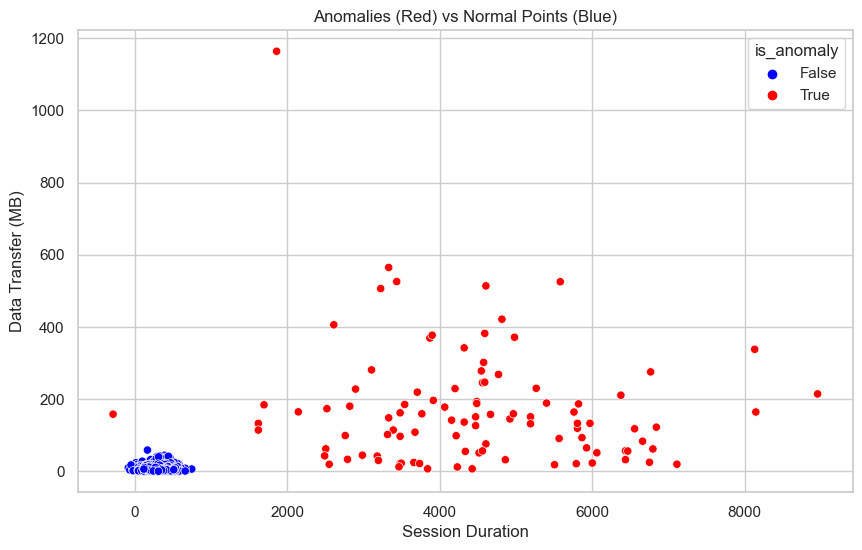

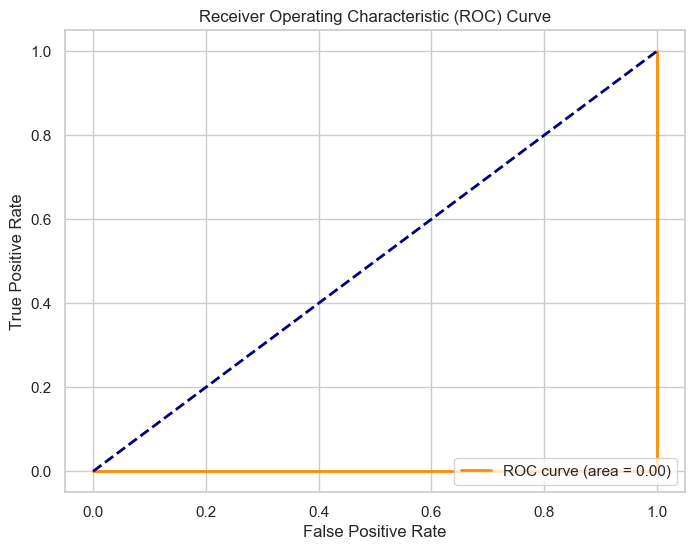

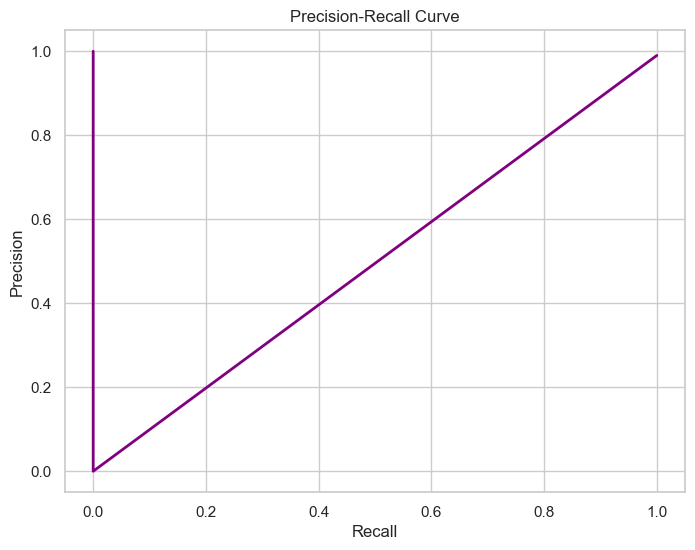

In [11]:
# Scatter plot: Visualizing anomalies vs. normal points
plt.figure(figsize=(10, 6))
sns.scatterplot(x='session_duration', y='data_transfer_MB', hue='is_anomaly', palette={0: 'blue', 1: 'red'}, data=isolation_forest_df)
plt.title("Anomalies (Red) vs Normal Points (Blue)")
plt.xlabel("Session Duration")
plt.ylabel("Data Transfer (MB)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(isolation_forest_df['anomaly_score'], isolation_forest_df['is_anomaly'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(isolation_forest_df['anomaly_score'], isolation_forest_df['is_anomaly'])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


**One-Class Support Vector Machines (SVM)**

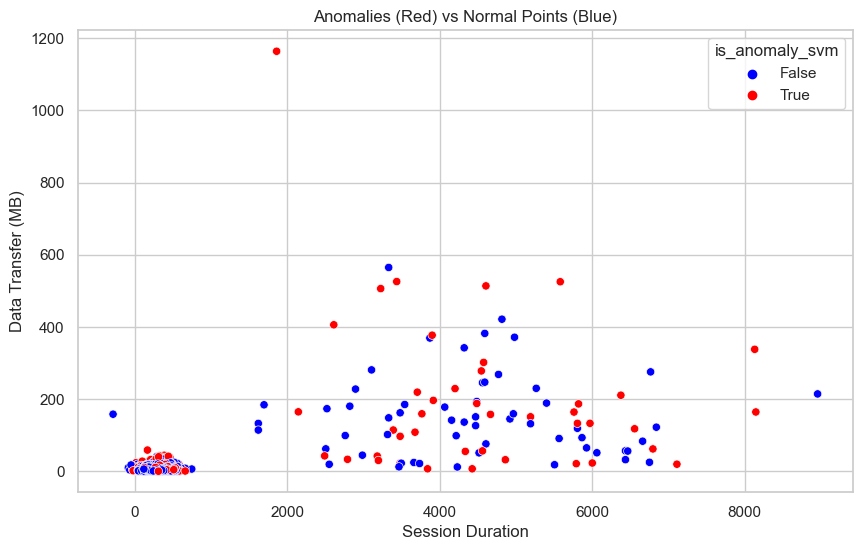

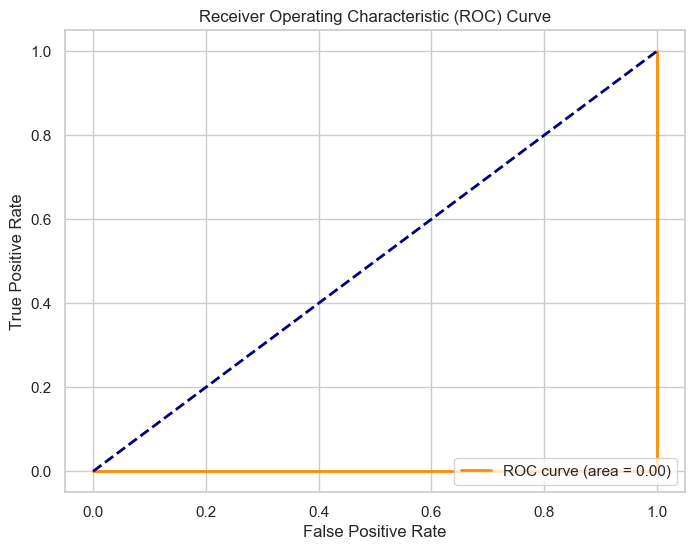

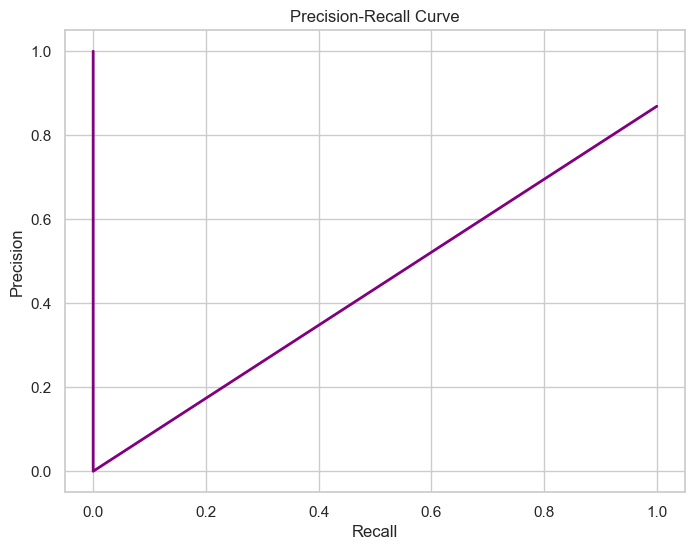

In [12]:
# Scatter plot: Visualizing anomalies vs. normal points
plt.figure(figsize=(10, 6))
sns.scatterplot(x='session_duration', y='data_transfer_MB', hue='is_anomaly_svm', palette={0: 'blue', 1: 'red'}, data=svm_df)
plt.title("Anomalies (Red) vs Normal Points (Blue)")
plt.xlabel("Session Duration")
plt.ylabel("Data Transfer (MB)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(svm_df['svm_score'], svm_df['is_anomaly_svm'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(svm_df['svm_score'], svm_df['is_anomaly_svm'])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


**DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**  

dbscan_labels_y_true_binary:  [0 1]
is_anomaly_dbscan_y_pred_True_False:  [False  True]


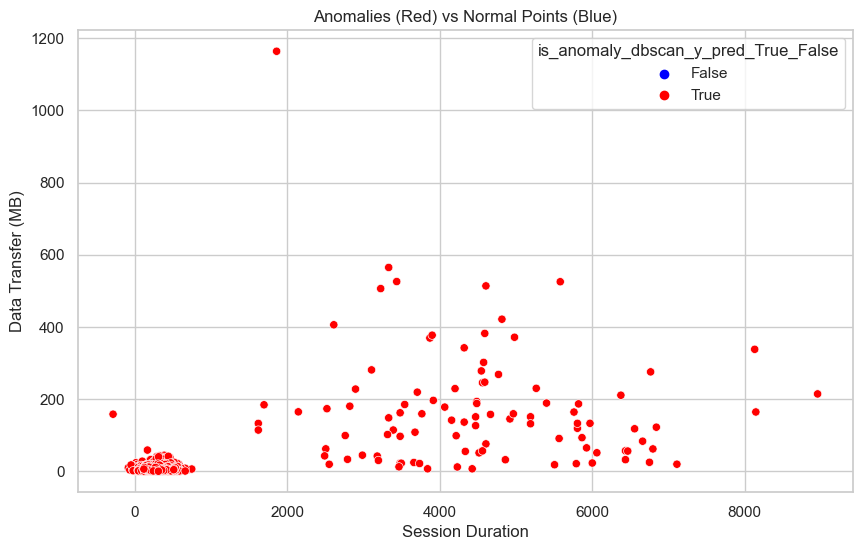

True count: 9323
False count: 677


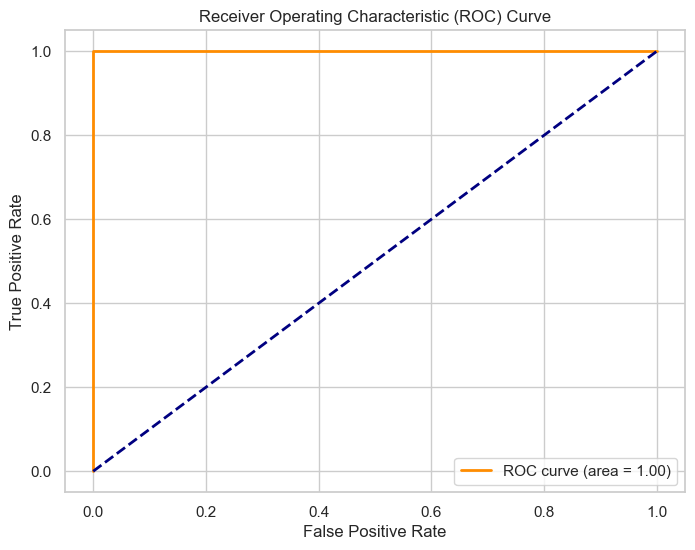

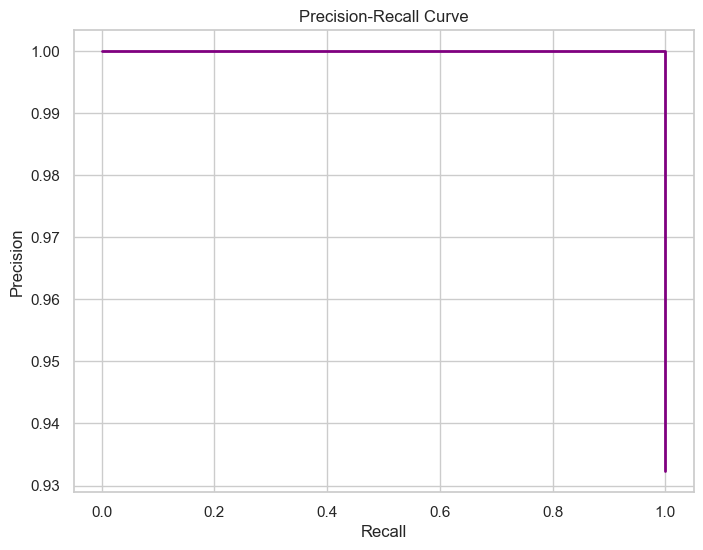

In [13]:
# Scatter plot: Visualizing anomalies vs. normal points
plt.figure(figsize=(10, 6))
print('dbscan_labels_y_true_binary: ', np.unique(dbscan_df['dbscan_labels_y_true_binary']))
#print('is_anomaly_dbscan_y_pred_binary: ',np.unique(dbscan_df['is_anomaly_dbscan_y_pred_binary']))
print('is_anomaly_dbscan_y_pred_True_False: ',np.unique(dbscan_df['is_anomaly_dbscan_y_pred_True_False']))

sns.scatterplot(x='session_duration', y='data_transfer_MB', hue='is_anomaly_dbscan_y_pred_True_False', palette={0: 'blue', 1: 'red'}, data=dbscan_df)
plt.title("Anomalies (Red) vs Normal Points (Blue)")
plt.xlabel("Session Duration")
plt.ylabel("Data Transfer (MB)")
plt.show()

counts = dbscan_df['is_anomaly_dbscan_y_pred_True_False'].value_counts()
print("True count:", counts.get(True, 0))
print("False count:", counts.get(False, 0))

# ROC Curve
#fpr, tpr, _ = roc_curve(dbscan_df['dbscan_labels'], dbscan_df['is_anomaly_dbscan'])
#roc_auc = auc(fpr, tpr)
#roc_auc = roc_auc_score(dbscan_df['dbscan_labels'], dbscan_df['is_anomaly_dbscan'])

fpr, tpr, _ = roc_curve(dbscan_df['dbscan_labels_y_true_binary'], dbscan_df['is_anomaly_dbscan_y_pred_True_False'])
#roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(dbscan_df['dbscan_labels_y_true_binary'], dbscan_df['is_anomaly_dbscan_y_pred_True_False'])


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
#precision, recall, _ = precision_recall_curve(dbscan_df['dbscan_labels'], dbscan_df['is_anomaly_dbscan'])
precision, recall, _ = precision_recall_curve(dbscan_df['dbscan_labels_y_true_binary'], dbscan_df['is_anomaly_dbscan_y_pred_True_False'])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()





##### **Interpretation:**

  - **Confusion Matrix:** This shows the number of correct and incorrect predictions, helping to gauge model accuracy.  
    Precision, Recall, and F1 Score: These metrics help assess the model’s effectiveness in identifying anomalies.
  - **Proportion of Detected Anomalies:** This shows the percentage of anomalies identified by the model, which helps  
    measure detection coverage.  
  - **Scatter Plot:** This visualization provides a direct view of where anomalies lie in relation to normal points, 
    helping to assess whether the model correctly isolates unusual points.  
  - **ROC Curve:** A higher Area Under the Curve (AUC) indicates better model performance.  
  - *Precision-Recall Curve:* This curve is particularly useful for imbalanced datasets, where anomalies (positive class)  
    are far less frequent.
These steps provide a comprehensive view of the model’s anomaly detection performance, combining quantitative metrics with visual insights.

#### Conclusion
This approach combines synthetic data generation with machine learning techniques  
to identify unusual patterns, forming a basis for real-world anomaly  
detection, especially in cybersecurity and fraud detection.